<b>Hyperparameters</b>: 
<br><b>win_tol</b>: window tolerance within which if a method detected cp, count that as true changepoint detected
<br>win_tol=2
<br>For BOCD: <b>run_length_threshold</b> - the change in run_length that constitutes a changepoint, for example if run_length_threshold is set to 4, then if run length drops by 4 or more, then that constitutes a changepoint
<br>For gradient based: <b>gradient_threshold</b>: the threshold above which a change in gradient constitutes a changepoint.
<br>For MC_dropout: <b>mc_dropout_threshold</b>: the threshold above which a change in variance in any of the output dimensions constitutes a changepoint
<br>
<br> <b>If TP=FP=0, Precision=1 rather than 0 and if TP=FN=0, then Recall=1 rather than 0 
<br> zero division is taken as 1 and not 0 for Precision and Recall</b>
<br> example: true_cps = [3, 31, 250, 273], pred_cps = [30, 31, 249, 250, 272, 300]
<br> TP = 3, FP = 1, FN = 1, TN = 317-5 = 312
<br> true changepoint 3 could not be detected but the rest were detected within the window tolerance
<br> false changepoint 300 was detected
<br>
<br>Precision = TP/(TP+FP)
<br>Recall or A_cp = TP/(TP+FN)
<br>A_cp = Accuracy for detecting changepoints (minority class)
<br>Accuracy = (TP+TN)/(TP+TN+FP+FN)
<br>A_major or A_no_cp = TN/(TN+FP)
<br>A_major or A_no_cp = Accuracy for detecting points that are not changepoints (majority class)
<br>Balanced_Accuracy = 1/2*(A_cp+A_major)

In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from   matplotlib.colors import LogNorm
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics

In [2]:
root_dir = "/home/users/richras/Ge2Net_Repo"
os.chdir(root_dir)

In [3]:
!./ini.sh

set environment variables
All done


In [4]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [5]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
from src.main.settings_model import parse_args, MODEL_CLASS
import test

# load the model and use valid data to choose hyperpparams for the different cp methods

In [6]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_16_data_id_1_geo/') 
dataset_type='valid'

In [7]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=False
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, valid_dataset=test.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 28.3514 secs
Finished '__init__' in 41.6643 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'l1_loss': 0.2580029092202422, 'mse': 0.05838709557964625, 'smooth_l1': 0.029178417158499795, 'weighted_loss': 0.2580029092202422, 'loss_main': 11692.480443670682, 'loss_aux': 13111.363826939725}
at epoch : 187
train loss metrics: {'l1_loss': 0.18102070288717145, 'mse': 0.03603976547629999, 'smooth_l1': 0.018013610915475323, 'weighted_loss': 0.18102070288717145, 'loss_main': 170953.0029025224, 'loss_aux': 12892599.370108439}
best val cp metrics : {'loss_cp': 0.09008311183681021, 'prMetrics': OrderedDict([('Precision', array(0.)), ('Recall', array(0.)), ('Accuracy', array(0.98634977)), ('A_major', array(1.)), ('BalancedAccuracy', 0.5)])}
train cp metrics: {'loss_cp': 0.20055664221354302, 'prMetrics': O

In [8]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [9]:
results.t_out.coord_main.shape

(3650, 317, 3)

In [10]:
results.t_accr, results.t_cp_accr

({'l1_loss': 0.2501775072517393,
  'loss_aux': 2916.666574478199,
  'loss_main': 1258.4053480834882,
  'mse': 0.05351993989884701,
  'smooth_l1': 0.026740676710421303,
  'weighted_loss': 0.2501775072517393},
 {'loss_cp': 0.1978821469132168,
  'prMetrics': OrderedDict([('Precision', array(0.03738318)),
               ('Recall', array(0.0005027)),
               ('Accuracy', array(0.99303747)),
               ('A_major', array(0.99991036)),
               ('BalancedAccuracy', 0.5002065330552647)])})

In [11]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps, minThresh, maxThresh, win_tol=2, byWindows=False):
    increment = (maxThresh - minThresh)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(minThresh, maxThresh + increment, increment):
        prMetrics, cp_pred = reportChangePointMetrics(method_name, cp_pred_raw, cp_target, thresh, win_tol)
        if byWindows: 
            prMetrics={}
            prMetrics['Precision']=precision_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Recall']=recall_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['BalancedAccuracy']=balanced_accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Accuracy']=accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['A_major']=(2*prMetrics['BalancedAccuracy'])-prMetrics['Recall']
        prMetrics['thresh']=thresh
        prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
        df=df.append(prMetrics, ignore_index=True)
    return df

# neural network, choose the threshold for logits

In [12]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5)
df_nn.style.background_gradient(cmap="Blues")

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Finished 'prMetricsByThresh' in 9.3168 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.02058142526369951,0.764107075530979,0.7483177045071518,0.7482083695575554,0.756158,0.400000,0.040083
1,0.021217487427684183,0.7333165765992208,0.7655278510003889,0.7657509009279493,0.749534,0.405000,0.041242
2,0.022173374365532954,0.6972477064220184,0.7864647163043949,0.7870825076821458,0.742165,0.410000,0.042980
3,0.023371048164179502,0.660927485233128,0.8077343243593622,0.8087509017982009,0.734839,0.415000,0.045146
4,0.024362904105784206,0.6173180847052909,0.8273618253316625,0.8288162925019994,0.723067,0.420000,0.046876
5,0.02560979679001635,0.5787357044112102,0.845675640637829,0.8475240907393918,0.713130,0.425000,0.049049
6,0.026695625193918708,0.5406560261405052,0.8612825720582515,0.8635027800186756,0.702079,0.430000,0.050879
7,0.027344150649244087,0.5025763478698002,0.8736389957218789,0.8762084531017071,0.689392,0.435000,0.051866
8,0.027931799793647613,0.47291692849063716,0.8831926018754591,0.8860335934515309,0.679475,0.440000,0.052748
9,0.059006211180124224,0.0023878346110343092,0.9928775765956528,0.9997363137709481,0.501062,0.445000,0.004590


In [13]:
nnThresh=0.455

# gradient method, choose the threshold for gradient difference in predictions

In [14]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 7.3317 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007086602251646075,1.0,0.03645823430275269,0.029786100863898744,0.514893,0.000000,0.014073
1,0.2221864434068588,0.6937287922583888,0.9811926883021477,0.9831832584481848,0.838456,0.050000,0.336575
2,0.45928529584065614,0.5911775794897575,0.9924022298085649,0.9951805467442583,0.793179,0.100000,0.516951
3,0.6232622798887859,0.507100666080181,0.9945023983406076,0.9978774563938689,0.752489,0.150000,0.559213
4,0.7317487266553481,0.4333291441498052,0.9950105872693488,0.9989000020015787,0.716115,0.200000,0.544321
5,0.8,0.3765238155083574,0.9950650360831425,0.9993481815658088,0.687936,0.250000,0.512049
6,0.851110416015014,0.3419630514012819,0.9950633075493712,0.99958576024743,0.670774,0.300000,0.487897
7,0.8866204885162231,0.3056428302123916,0.9949561384555551,0.9997293517582998,0.652686,0.350000,0.454579
8,0.909466721785862,0.27648611285660424,0.9948351410915691,0.9998094149037545,0.638148,0.400000,0.424056
9,0.9287045666356011,0.2504712831469147,0.9947132794606974,0.9998668515081025,0.625169,0.450000,0.394536


In [15]:
gradThresh=0.1

# mc dropout variance, choose the threshold for difference in variance

In [16]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.5)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 6.3886 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007063753101544225,1.0,0.033319216974201635,0.026625347121599384,0.513313,0.000000,0.014028
1,0.06003818683261438,0.32009551338444137,0.9608608098180719,0.9652978479548653,0.642697,0.025000,0.101112
2,0.08307459295721317,0.1378660299107704,0.9836065857136684,0.9894629938568941,0.563665,0.050000,0.103676
3,0.10820610687022901,0.07125801181349754,0.989574348558835,0.9959333143618488,0.533596,0.075000,0.085929
4,0.12759226713532512,0.045620208621339704,0.9912916468605505,0.9978400355758846,0.521730,0.100000,0.067210
5,0.14410005437737902,0.033304009048636424,0.9919917030378981,0.9986302240114595,0.515967,0.125000,0.054104
6,0.16679477325134512,0.02727158476812869,0.9923737090013396,0.999056647286164,0.513164,0.150000,0.046878
7,0.18278427205100956,0.021616187005152696,0.9926070610604555,0.9993307765341882,0.510473,0.175000,0.038660
8,0.189873417721519,0.016966193288927987,0.9927418866946113,0.999498735089327,0.508232,0.200000,0.031149
9,0.2164750957854406,0.014201332160361945,0.9928672053930254,0.999644067103359,0.506923,0.225000,0.026654


In [17]:
varThresh=0.025

# BOCD, Compute the run lengths and changepoints by using a multivariate Gaussian (with independent three dimensions of predictions) to model the prediction sequence

In [18]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 191.7642 secs


In [19]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20,1,11)
df_bocd.style.background_gradient(cmap="Blues")

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Finished 'prMetricsByThresh' in 17.0761 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.0,0.0,0.9931230283911672,1.0,0.500000,0.000000,nan
1,0.0,0.0,0.9931230283911672,1.0,0.500000,0.500000,nan
2,0.7476564479351406,0.37086841774538143,0.9948126701525432,0.9991332294252946,0.685001,1.000000,0.495800
3,0.7476564479351406,0.37086841774538143,0.9948126701525432,0.9991332294252946,0.685001,1.500000,0.495800
4,0.6288981288981289,0.5322357672489632,0.9946233957045936,0.9978252412990072,0.765031,2.000000,0.576543
5,0.6288981288981289,0.5322357672489632,0.9946233957045936,0.9978252412990072,0.765031,2.500000,0.576543
6,0.548768826201291,0.5769762473293955,0.9938282701698284,0.9967148002816134,0.786846,3.000000,0.562519
7,0.548768826201291,0.5769762473293955,0.9938282701698284,0.9967148002816134,0.786846,3.500000,0.562519
8,0.4870689655172414,0.5964559507352017,0.9929052331359924,0.9956504825980143,0.796053,4.000000,0.536241
9,0.4870689655172414,0.5964559507352017,0.9929052331359924,0.9956504825980143,0.796053,4.500000,0.536241


In [20]:
bocdThresh=2.0

# Summary Table with chosen thresholds

In [21]:
pd.options.display.float_format='{:,.4f}'.format
df_summary=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
cpThresh=[nnThresh, gradThresh, varThresh, bocdThresh]
cp_target=valid_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, cp_target, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary=df_summary.append(prMetrics, ignore_index=True)
df_summary

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.02127659574468085,0.00012567550584391103,0.9930841363813145,0.9999599684272726,0.5000,0.4550,0.0002,neural_network
1,0.45928529584065614,0.5911775794897575,0.9924022298085649,0.9951805467442583,0.7932,0.1000,0.5170,gradient
2,0.06003818683261438,0.32009551338444137,0.9608608098180719,0.9652978479548653,0.6427,0.0250,0.1011,mc_dropout
3,0.6288981288981289,0.5322357672489632,0.9946233957045936,0.9978252412990072,0.7650,2.0000,0.5765,BOCD


plot of Precision/Recall

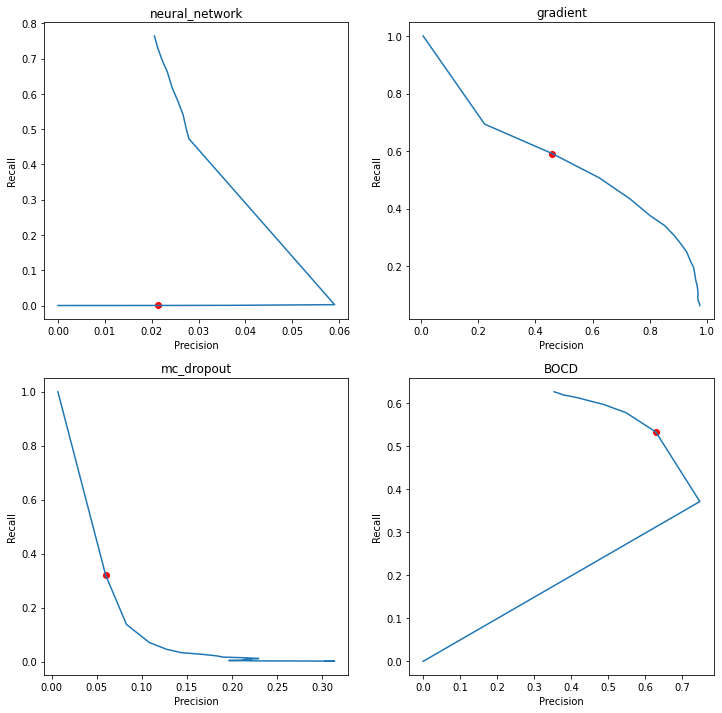

In [22]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
    df_row=df_summary[df_summary.Name==name]
    ax[row,col].scatter(df_row['Precision'], df_row['Recall'], color='r')
plt.show()

# Qualitative by looking at anecdotes/samples

In [23]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
pred_cps = {}
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, thresh)

true_cps=cp_target.detach().cpu().numpy()
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

In [24]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(8,1,figsize=[18,30])
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=10)
    ax[1].plot(pred_cps[cpMethod.gradient.name])
    ax[2].plot(y_var)
    ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[4].plot(pred_cps[cpMethod.neural_network.name])
    ax[5].plot(np.arange(T+1), bocp_rl)
    ax[6].plot(pred_cps[cpMethod.BOCD.name])
    ax[7].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("Simple gradient(post_process)")
    ax[2].set_title("Mc dropout variance")
    ax[3].set_title("Mc dropout")
    ax[4].set_title("Neural Network predicted cp")
    ax[5].set_title("BOCD (post process) run_length")
    ax[6].set_title("BOCD (post process) cp")
    ax[7].set_title("True Cps")
    plt.show()

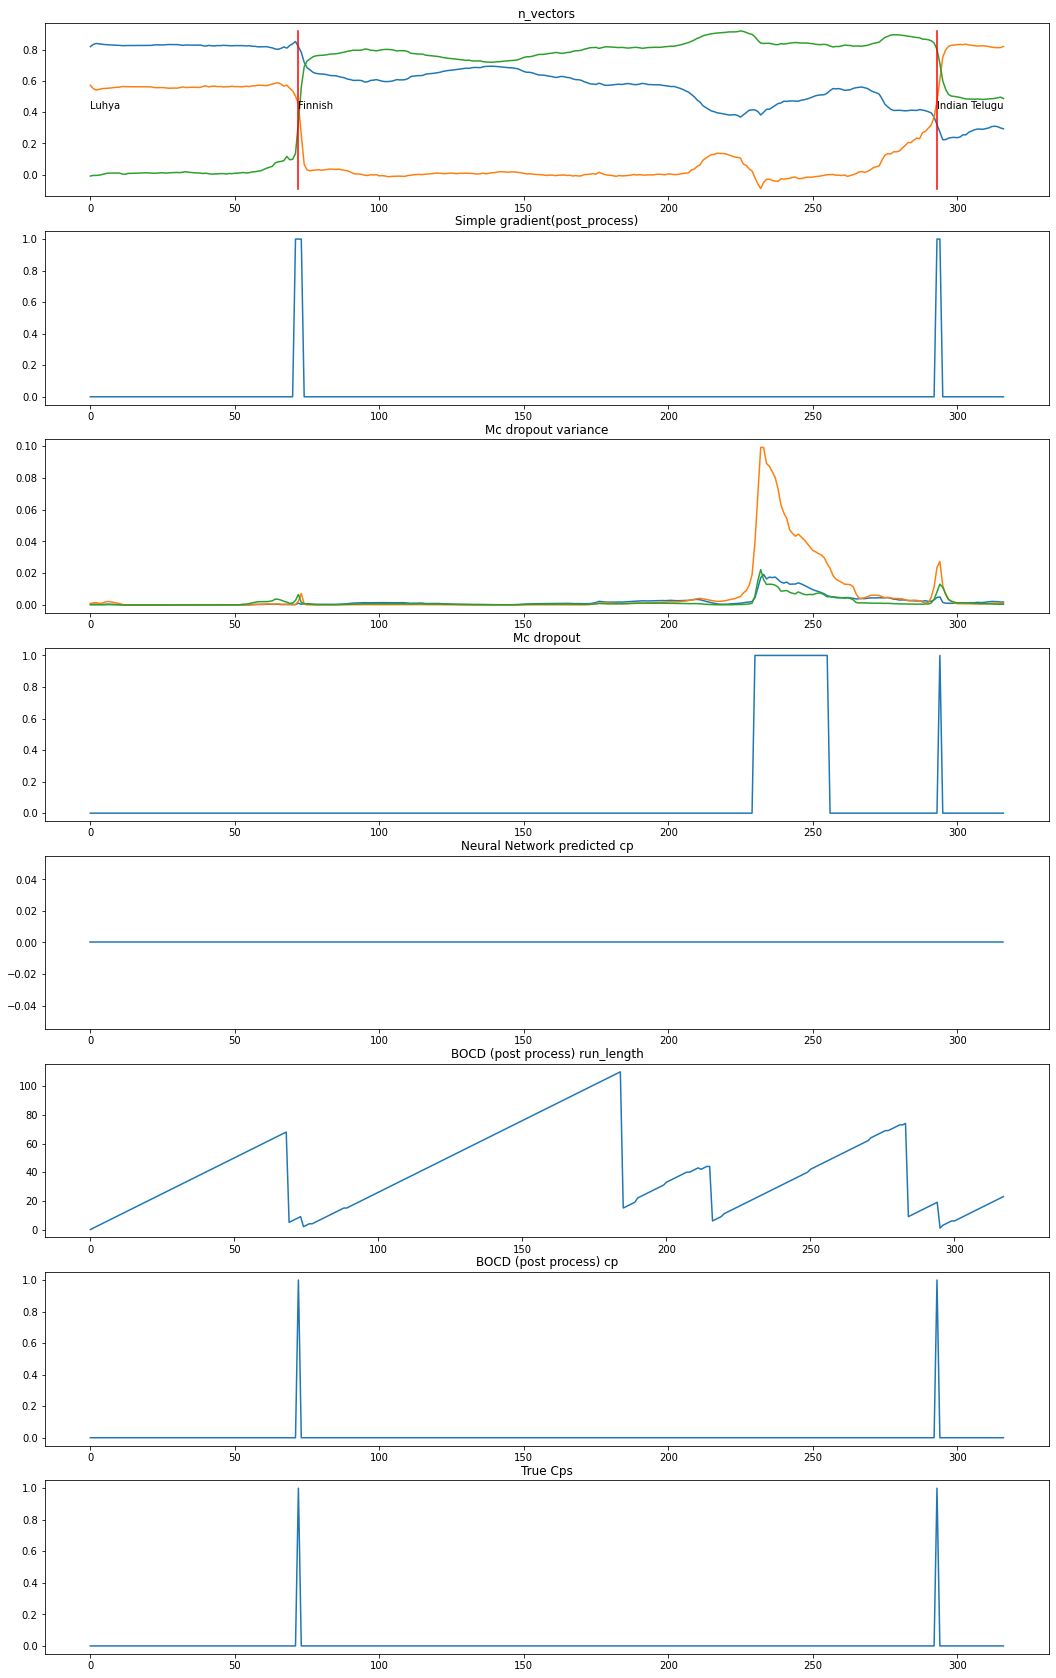

In [25]:
index = 2000
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

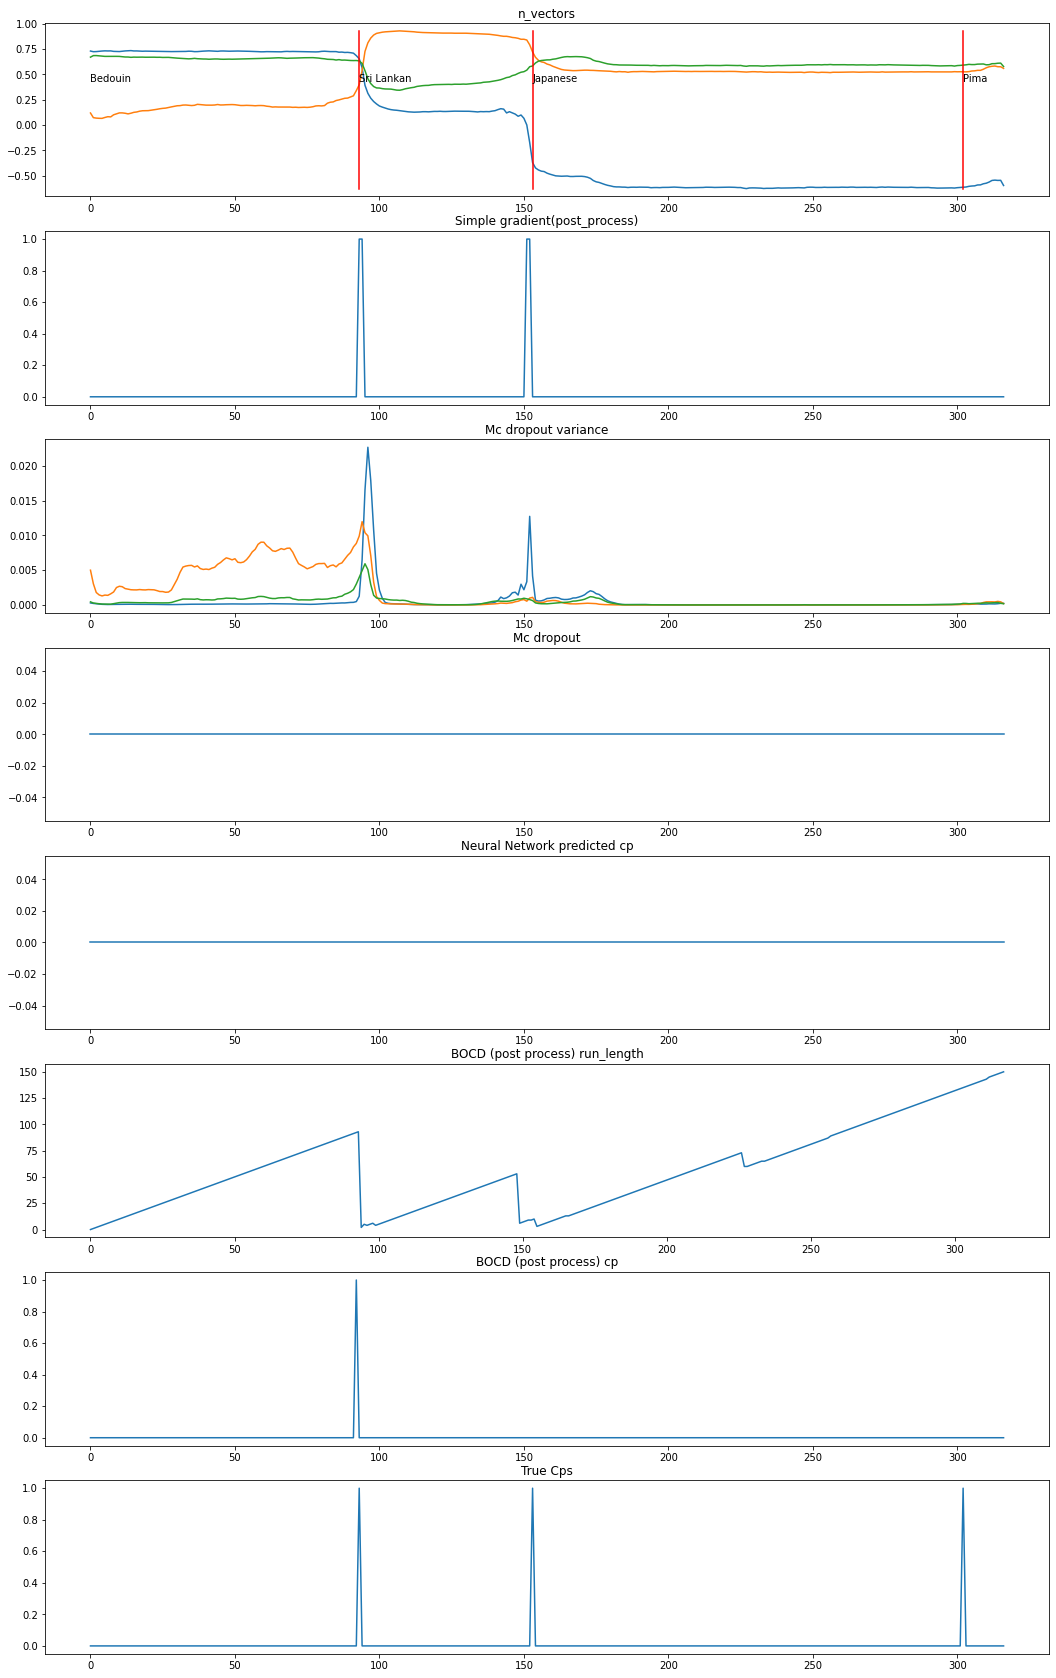

In [26]:
index = 2620
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

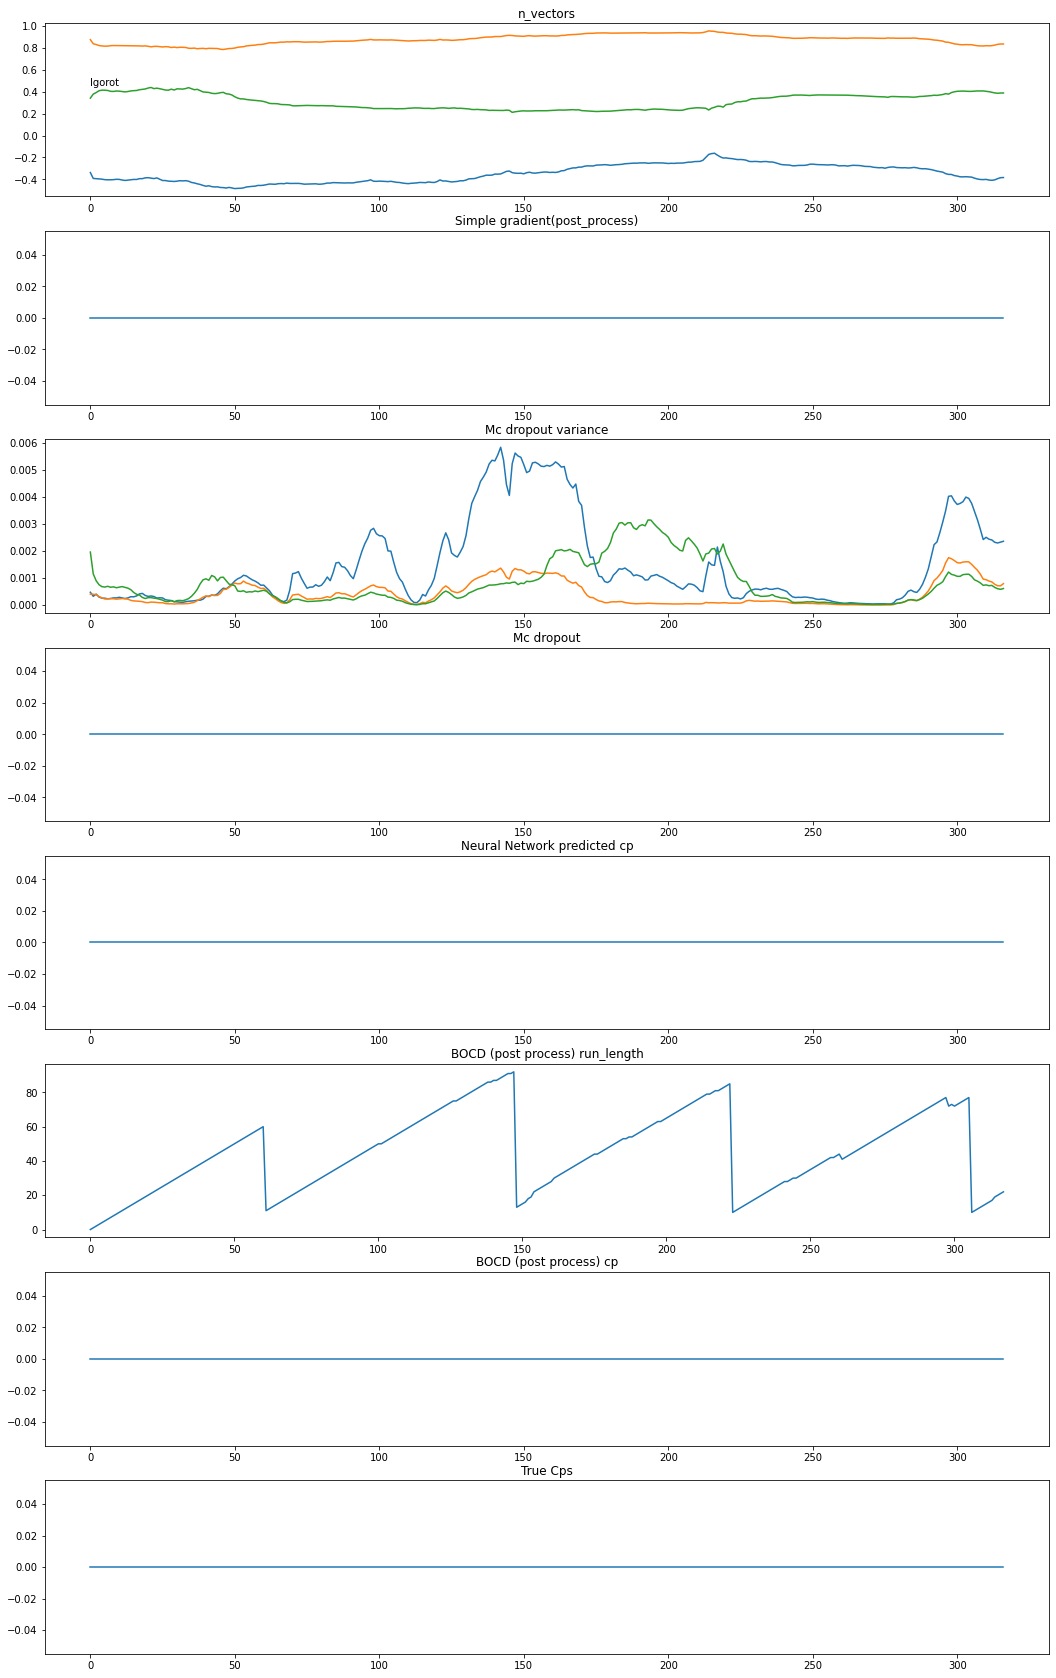

In [27]:
index = 1200
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

# evaluate on a subset of samples that have at least 1 changepoint 


In [28]:
subset_idx=torch.unique(torch.nonzero(valid_dataset.data['cps'])[:,0])

In [29]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'].unsqueeze(2)[subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.04,0.00012567550584391103,0.98842065244835,0.9999647681080914,0.5000,0.4550,0.0003,neural_network
1,0.5221445221445221,0.5911775794897575,0.9890329938852919,0.9936802793889028,0.7924,0.1000,0.5545,gradient
2,0.08440482502651113,0.32009551338444137,0.9520588892532627,0.9594407524357715,0.6398,0.0250,0.1336,mc_dropout
3,0.7127229888926288,0.5322357672489632,0.9921222709451243,0.9974941316880039,0.7649,2.0000,0.6094,BOCD


# compute metrics by placing win_tol=0

In [30]:
df_zero_tol=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=valid_dataset.data['cps'].unsqueeze(2).float()
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_zero_tol=df_zero_tol.append(prMetrics, ignore_index=True)
df_zero_tol

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.0,0.0,0.9930824078475433,0.9999590981756916,0.5000,0.4550,nan,neural_network
1,0.2303962648150365,0.48372502199321354,0.9853377122855538,0.9888111754227029,0.7363,0.1000,0.3121,gradient
2,0.03003631988235032,0.16941058187759206,0.9566656583553002,0.9621170784262022,0.5658,0.0250,0.0510,mc_dropout
3,0.25466390287237195,0.21616187005152696,0.9902588479322415,0.9956191535410972,0.6059,2.0000,0.2338,BOCD


# evaluate to make sure matches with scikit learn (subset with samples that have cp, and win_tol=0 for evaluation

In [31]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'].unsqueeze(2)[subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.0,0.0,0.9884177503562318,0.9999633001125953,0.5000,0.4550,nan,neural_network
1,0.2487558973696116,0.48372502199321354,0.9771721433981757,0.9829360203522896,0.7333,0.1000,0.3286,gradient
2,0.0413091443981368,0.16941058187759206,0.9450155116823719,0.9540752288971978,0.5617,0.0250,0.0664,mc_dropout
3,0.2884937940288494,0.21616187005152696,0.9847944883466491,0.9937727631051628,0.6050,2.0000,0.2471,BOCD


# evaluate by Windows

In [32]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5, byWindows=True)
df_nn.style.background_gradient(cmap="Blues")

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/users/richras/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished 'prMetricsByThresh' in 128.4395 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006767,0.254493,0.738004,0.741352,0.497922,0.400000,0.013184
1,0.006821,0.238658,0.755799,0.759380,0.499019,0.405000,0.013263
2,0.006887,0.219052,0.777393,0.781259,0.500156,0.410000,0.013354
3,0.007099,0.202966,0.799309,0.803439,0.503202,0.415000,0.013719
4,0.007164,0.183361,0.819641,0.824047,0.503704,0.420000,0.013790
5,0.007352,0.167651,0.838602,0.843249,0.505450,0.425000,0.014086
6,0.007489,0.152947,0.854786,0.859646,0.506296,0.430000,0.014280
7,0.007445,0.137866,0.867671,0.872725,0.505295,0.435000,0.014127
8,0.007497,0.127812,0.877637,0.882829,0.505321,0.440000,0.014163
9,0.012422,0.000503,0.992852,0.999723,0.500113,0.445000,0.000966


In [33]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1, byWindows=True)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 52.2908 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006899,1.000000,0.010032,0.003176,0.501588,0.000000,0.013703
1,0.131463,0.604248,0.969825,0.972356,0.788302,0.050000,0.215944
2,0.230396,0.483725,0.985338,0.988811,0.736268,0.100000,0.312127
3,0.305275,0.399271,0.989620,0.993708,0.696490,0.150000,0.346003
4,0.366268,0.338695,0.991422,0.995942,0.667319,0.200000,0.351943
5,0.417594,0.292321,0.992330,0.997177,0.644749,0.250000,0.343905
6,0.457639,0.255247,0.992798,0.997905,0.626576,0.300000,0.327713
7,0.495933,0.222194,0.993098,0.998436,0.610315,0.350000,0.306891
8,0.528898,0.197813,0.993272,0.998780,0.598297,0.400000,0.287936
9,0.566869,0.176323,0.993409,0.999067,0.587695,0.450000,0.268980


In [34]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.5, byWindows=True)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 51.2082 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006877,1.000000,0.006877,0.000000,0.500000,0.000000,0.013660
1,0.030036,0.169411,0.956666,0.962117,0.565764,0.025000,0.051026
2,0.036415,0.063466,0.982010,0.988371,0.525918,0.050000,0.046277
3,0.040930,0.028528,0.988722,0.995371,0.511950,0.075000,0.033622
4,0.048845,0.018600,0.990760,0.997492,0.508046,0.100000,0.026941
5,0.053408,0.013196,0.991605,0.998380,0.505788,0.125000,0.021163
6,0.061239,0.010682,0.992070,0.998866,0.504774,0.150000,0.018192
7,0.058590,0.007415,0.992355,0.999175,0.503295,0.175000,0.013164
8,0.057971,0.005530,0.992543,0.999378,0.502454,0.200000,0.010096
9,0.069519,0.004901,0.992706,0.999546,0.502224,0.225000,0.009157


In [35]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20,1,11, byWindows=True)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 63.1410 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.324352,0.158854,0.991940,0.997709,0.578281,1.000000,0.213261
1,0.324352,0.158854,0.991940,0.997709,0.578281,1.500000,0.213261
2,0.254664,0.216162,0.990259,0.995619,0.605891,2.000000,0.233839
3,0.254664,0.216162,0.990259,0.995619,0.605891,2.500000,0.233839
4,0.211123,0.224708,0.988894,0.994186,0.609447,3.000000,0.217704
5,0.211123,0.224708,0.988894,0.994186,0.609447,3.500000,0.217704
6,0.184136,0.228729,0.987727,0.992982,0.610856,4.000000,0.204024
7,0.184136,0.228729,0.987727,0.992982,0.610856,4.500000,0.204024
8,0.167823,0.231117,0.986831,0.992064,0.611591,5.000000,0.194449
9,0.167823,0.231117,0.986831,0.992064,0.611591,5.500000,0.194449


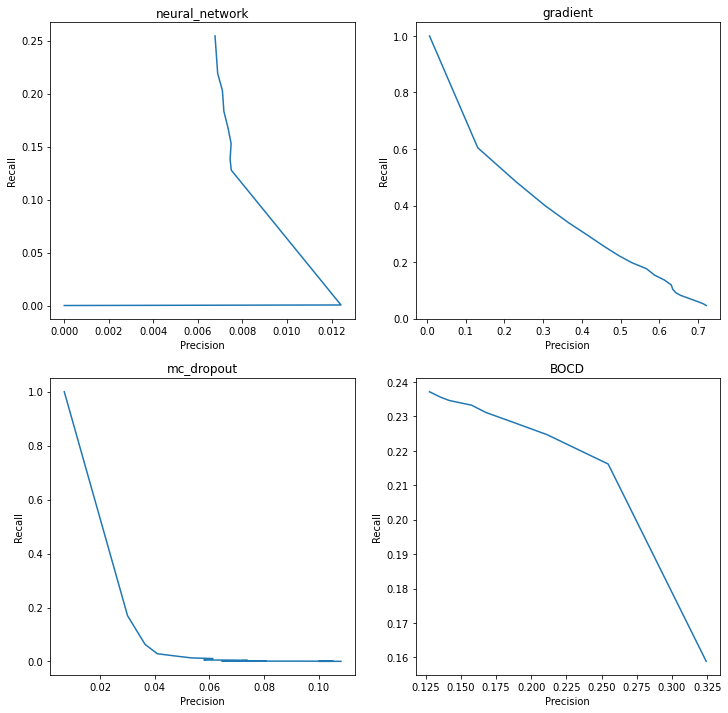

In [36]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
plt.show()

# load the model and evaluate with test data on the chosen hyperparameters

In [37]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_9_data_id_1_geo/') 
dataset_type='test'

In [38]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=False
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, test_dataset=test.main(config, params)
results.t_out.coord_main=results.t_out.coord_main.mean(0)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 16.6838 secs
Finished '__init__' in 87.8651 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'l1_loss': 0.2528095822552504, 'mse': 0.060184916821064346, 'smooth_l1': 0.030036991086910138, 'weighted_loss': 0.2528095822552504, 'loss_main': 1087.0188012618296, 'loss_aux': 2346.6816334644136}
at epoch : 499
train loss metrics: {'l1_loss': 0.13092479523915124, 'mse': 0.026870303912922156, 'smooth_l1': 0.013421181732888374, 'weighted_loss': 0.13092479523915124, 'loss_main': 594.8854704321795, 'loss_aux': 2130.4857966353725}
best val cp metrics : {'loss_cp': 0.09881759427936347, 'Precision': 1.0, 'Recall': 0.4043835616438356, 'Accuracy': 0.9863497688086083, 'A_major': 1.0, 'BalancedAccuracy': 0.7021917808219178}
train cp metrics: {'loss_cp': 0.19673313592130898, 'Precision': 0.030794964379797396, 'R

# Summary Table with test data

compute BOCD

In [39]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
test_tensor = torch.tensor(y_pred).float()
batch_size_cpd = test_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(test_tensor, 'cpu')

Finished 'run_recursive' in 151.3230 secs


In [40]:
df_test=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=test_dataset.data['cps'].unsqueeze(2).float()
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_test=df_test.append(prMetrics, ignore_index=True)
df_test

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.037383177570093455,0.001009845998485231,0.9913579143198934,0.9997788907183476,0.5004,0.4550,0.0020,neural_network
1,0.5147826086956522,0.6351931330472103,0.9918762266014466,0.9949091197918567,0.8151,0.1000,0.5687,gradient
2,0.0772551003203507,0.289194647816208,0.9648835447025718,0.9706289593051587,0.6299,0.0250,0.1219,mc_dropout
3,0.6626349892008639,0.5809139106286292,0.9939728902455118,0.9974851502577103,0.7892,2.0000,0.6191,BOCD
